In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split,StratifiedKFold
import os
import keras
from keras import backend as K
from keras.utils import Sequence
from PIL import Image
import cv2
import albumentations
import segmentation_models as sm
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout,BatchNormalization
from keras.layers import Conv2D, Concatenate, MaxPooling2D , MaxPool2D, UpSampling2D
from keras.layers import UpSampling2D, Dropout, BatchNormalization, Multiply
from keras.layers import LeakyReLU, Dense, GlobalAveragePooling2D, Lambda, GlobalMaxPooling2D
from keras.layers import ZeroPadding2D
from keras.losses import binary_crossentropy
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add, add, multiply
from keras.layers.merge import concatenate, add
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from classification_models import Classifiers
from tqdm import tqdm_notebook
import keras.callbacks as callbacks
import tensorflow as tf
import seaborn as sns
import shutil

from collections import defaultdict

Using TensorFlow backend.
C:\Users\a2720\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\a2720\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\a2720\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\a2720\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [29]:
train_dir = './severstal-steel-defect-detection/train_images'
mask_dir = './severstal-steel-defect-detection/train.csv'

test_dir = './severstal-steel-defect-detection/test_images'


epochs = 80
batch_size = 26
swa_nb = epochs-5

lr = 0.001
image_size = (256,1600)
shrink = 2

channels = 3


model_name = 'Unetpluscbam'

(256, 1600, 3)


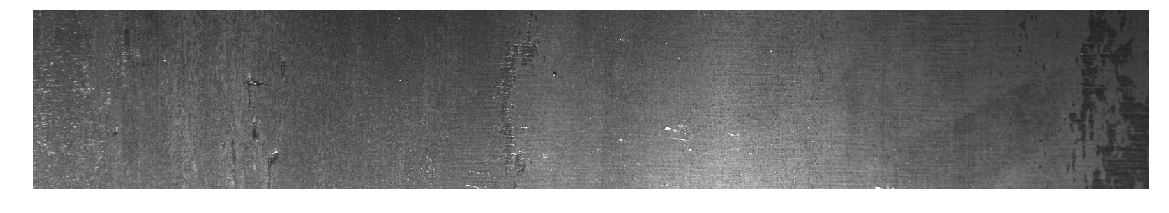

In [3]:
train_dir_image_check = glob.glob(train_dir+'/*')[0]
#train_dir_image_check = './severstal-steel-defect-detection/train_images/005d86c25.jpg'
img = Image.open(train_dir_image_check)
plt.figure(figsize=(20,4))
plt.imshow(img)
plt.axis('off')

print(np.array(img).shape)

In [4]:
256//2

128

In [5]:
def rle2mask(rle, imgshape ,shrink = 1):   
    if (pd.isnull(rle))|(rle==''): 
        return np.zeros((imgshape[0]//shrink,imgshape[1]//shrink) ,dtype=np.uint8)
    height= imgshape[0]
    width = imgshape[1]
    mask= np.zeros( width*height ,dtype=np.uint8)

    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]    
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
    
    return mask.reshape( (height,width), order='F' )[::shrink,::shrink]

In [6]:
train_dir_image_check

'./severstal-steel-defect-detection/train_images\\0002cc93b.jpg'

In [7]:
mask_df = pd.read_csv(mask_dir)
mask_df.head(10)

,ImageId_ClassId,EncodedPixels
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0002cc93b.jpg_2,NaN
2,0002cc93b.jpg_3,NaN
3,0002cc93b.jpg_4,NaN
4,00031f466.jpg_1,NaN
5,00031f466.jpg_2,NaN
6,00031f466.jpg_3,NaN
7,00031f466.jpg_4,NaN
8,000418bfc.jpg_1,NaN
9,000418bfc.jpg_2,NaN


In [8]:
for col in range(0, len(mask_df), 4):
    img_names = [str(i).split("_")[0] for i in mask_df.iloc[col:col+4, 0].values]
    if img_names[0] == train_dir_image_check.split('\\')[-1]:
        mask_test = np.empty((4, np.array(img).shape[0], np.array(img).shape[1], 1))
        for idx in range(4):
            temp_mask = rle2mask(mask_df.iloc[col+idx, 1],(np.array(img).shape[0], np.array(img).shape[1]))
            mask_test[idx] = temp_mask.reshape((temp_mask.shape[0],temp_mask.shape[1],1))
        break

In [9]:
mask_test.shape

(4, 256, 1600, 1)

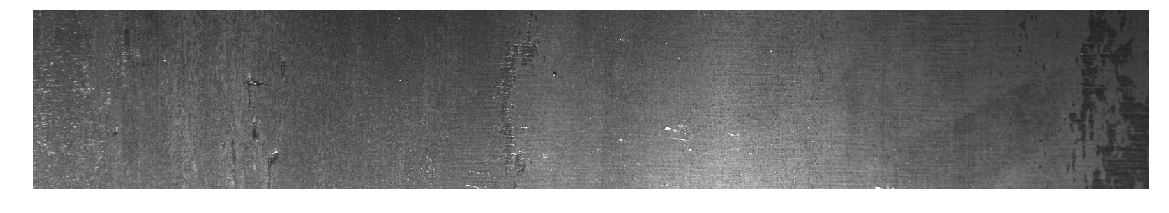

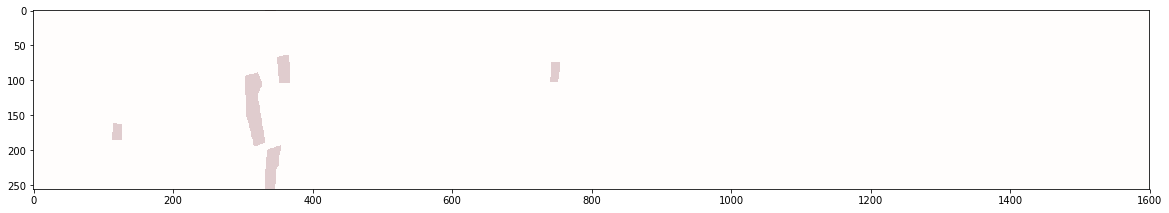

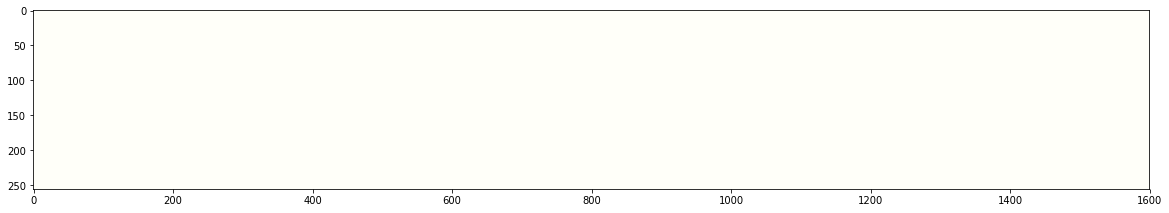

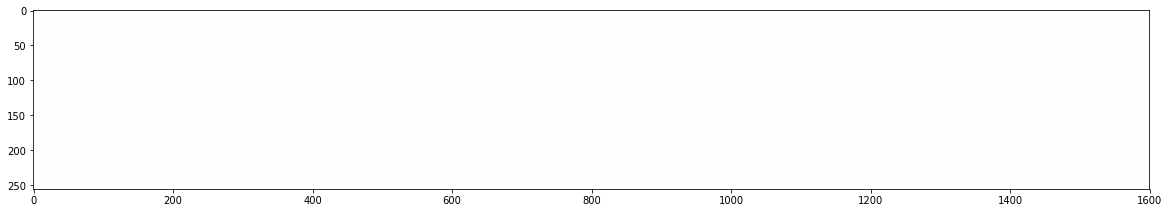

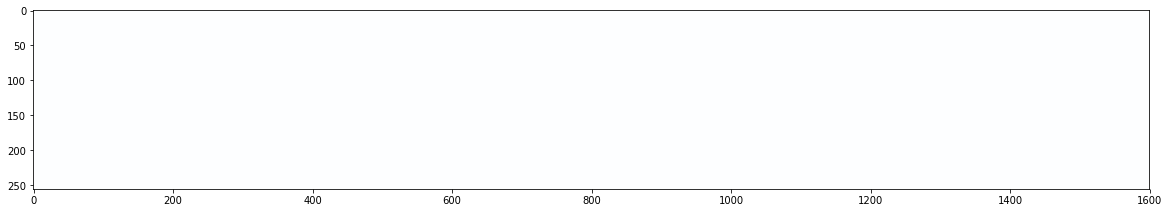

In [10]:
plt.figure(figsize=(20,4))
plt.imshow(img),plt.axis('off')
color = ['Reds', 'YlOrBr', 'Greens', 'Blues']
for idx in range(4):
    plt.figure(figsize=(20,4))
    plt.imshow(mask_test[idx].squeeze(),cmap=color[idx],alpha=0.2)
plt.show()

the number of images with no defects: 5902
the number of images with defects: 6666


defaultdict(int, {1: 6239, 0: 5902, 2: 425, 3: 2})

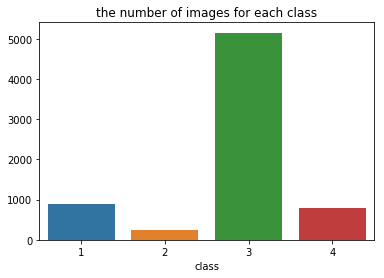

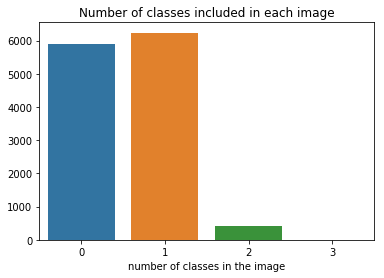

In [11]:
#https://www.kaggle.com/go1dfish/clear-mask-visualization-and-simple-eda

class_dict = defaultdict(int)

kind_class_dict = defaultdict(int)

no_defects_num = 0
defects_num = 0

for col in range(0, len(mask_df), 4):
    img_names = [str(i).split("_")[0] for i in mask_df.iloc[col:col+4, 0].values]
    if not (img_names[0] == img_names[1] == img_names[2] == img_names[3]):
        raise ValueError
        
    labels = mask_df.iloc[col:col+4, 1]
    if labels.isna().all():
        no_defects_num += 1
    else:
        defects_num += 1
    
    kind_class_dict[sum(labels.isna().values == False)] += 1
        
    for idx, label in enumerate(labels.isna().values.tolist()):
        if label == False:
            class_dict[idx+1] += 1
            
print("the number of images with no defects: {}".format(no_defects_num))
print("the number of images with defects: {}".format(defects_num))


fig, ax = plt.subplots()
sns.barplot(x=list(class_dict.keys()), y=list(class_dict.values()), ax=ax)
ax.set_title("the number of images for each class")
ax.set_xlabel("class")
class_dict


fig, ax = plt.subplots()
sns.barplot(x=list(kind_class_dict.keys()), y=list(kind_class_dict.values()), ax=ax)
ax.set_title("Number of classes included in each image");
ax.set_xlabel("number of classes in the image")
kind_class_dict

In [12]:
train_fn = glob.glob(train_dir+'/*')
split_use = pd.DataFrame()
split_use['name'] = [name.split('\\')[-1] for name in train_fn]
split_use['has_defect'] = 0
split_use.set_index('name',inplace=True)
for col in range(0, len(mask_df), 4):
    img_names = [str(i).split("_")[0] for i in mask_df.iloc[col:col+4, 0].values]
    if not (img_names[0] == img_names[1] == img_names[2] == img_names[3]):
        raise ValueError
    labels = mask_df.iloc[col:col+4, 1]
    if labels.isna().all():
        split_use.loc[img_names[0],'has_defect']= 0
    else:
        split_use.loc[img_names[0],'has_defect'] = 1
split_use.reset_index(inplace=True)

In [13]:
split_use.head(5)

,name,has_defect
0,0002cc93b.jpg,1
1,00031f466.jpg,0
2,000418bfc.jpg,0
3,000789191.jpg,0
4,0007a71bf.jpg,1


In [14]:
train_set , val_set = train_test_split(train_fn, stratify=split_use.has_defect, test_size=0.15)

print('No. of train files:', len(train_set))
print('No. of val files:', len(val_set))

No. of train files: 10682
No. of val files: 1886


In [15]:
TRAIN_DIR = './im_train'
if not os.path.exists(TRAIN_DIR):
    os.mkdir(TRAIN_DIR)
for item in train_set:
    fn = item.split("\\")[-1]
    dist = os.path.join(TRAIN_DIR,fn)
    if not os.path.exists(dist):
        shutil.copyfile(item,dist)
        

VAL_DIR = './im_val'
if not os.path.exists(VAL_DIR):
    os.mkdir(VAL_DIR)
for item in val_set:
    fn = item.split('\\')[-1]
    dist = os.path.join(VAL_DIR,fn)
    if not os.path.exists(dist):
        shutil.copyfile(item,dist)

print('No. of train files:', len(glob.glob(TRAIN_DIR+'/*')))
print('No. of val files:', len(glob.glob(VAL_DIR+'/*')))

No. of train files: 12520
No. of val files: 4859


In [16]:
mask_df = pd.read_csv(mask_dir)
mask_df_m = mask_df.set_index('ImageId_ClassId',inplace=True)
mask_df.head(5)

,EncodedPixels
ImageId_ClassId,
0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
0002cc93b.jpg_2,NaN
0002cc93b.jpg_3,NaN
0002cc93b.jpg_4,NaN
00031f466.jpg_1,NaN


In [47]:
class Datagen(Sequence):
    def __init__(self, train_dir = TRAIN_DIR, mask_dir = mask_dir, augmentation = None,
                 batch_size = batch_size, shuffle = True, image_size = image_size,
                 shrink = shrink, preprocess = None, subset = 'train'):
        self.train_dir = train_dir
        self.train_dirs = glob.glob(train_dir+'/*')
        self.mask_df = pd.read_csv(mask_dir)
        self.mask_df.set_index('ImageId_ClassId',inplace=True)
        self.augment = augmentation
        self.batch_size = batch_size
        self.shuffle = shuffle            
        self.image_size = image_size
        self.shrink = shrink                 ## image size shrink
        self.subset = subset
        self.preprocess = preprocess   ## imagenet preprocess
        self.on_epoch_end()

    def __getitem__(self,index):
        # get the indexes
        indexes = self.indexes[(index)*self.batch_size:min((index+1)*self.batch_size,len(self.train_dirs))]

        # list of items
        list_id_items = [self.train_dirs[x] for x in indexes]
        image, mask = self.data_generator(list_id_items)

        if self.augment is None:
            if self.subset == 'train': return image, mask
            else: return image
        else:
            images = [] ; masks = [] 
            for x, y in zip(image,mask):
                augment_result = self.augment(image = x, mask = y)
                images.append(augment_result['image'])
                masks.append(augment_result['mask'])
            if self.subset == 'train': return np.array(images), np.array(masks)
            else: return np.array(images)
        
    def __len__(self):
        return int(np.ceil(len(self.train_dirs)/self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.train_dirs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def data_generator(self,list_id_items):
        batch_size = len(list_id_items)
        w = self.image_size[0]//self.shrink
        h = self.image_size[1]//self.shrink
        
        images = np.empty((batch_size, w, h, 3))
        masks = np.empty((batch_size, w, h , 4))   #4 type of mask
        
        for i , data in enumerate(list_id_items):
            # get source image
            
            image_size = (w, h)
            im = cv2.resize(np.array(Image.open(data)),(h,w))
            if len(im.shape)==2:
                im = np.repeat(im[...,None],3,2)

                
            if self.subset == 'train': 
                d_name = data.split('\\')[-1]
                for idx in range(4):
                    rle = self.mask_df.loc[d_name+'_{}'.format(idx+1),'EncodedPixels']
                    masks[i,:,:,idx] = rle2mask(rle,self.image_size,self.shrink)
                
            if self.preprocess!=None: im = self.preprocess(im)
            images[i,] = im
            masks[masks>0] = 1.
            
        return np.uint8(images), np.uint8(masks)

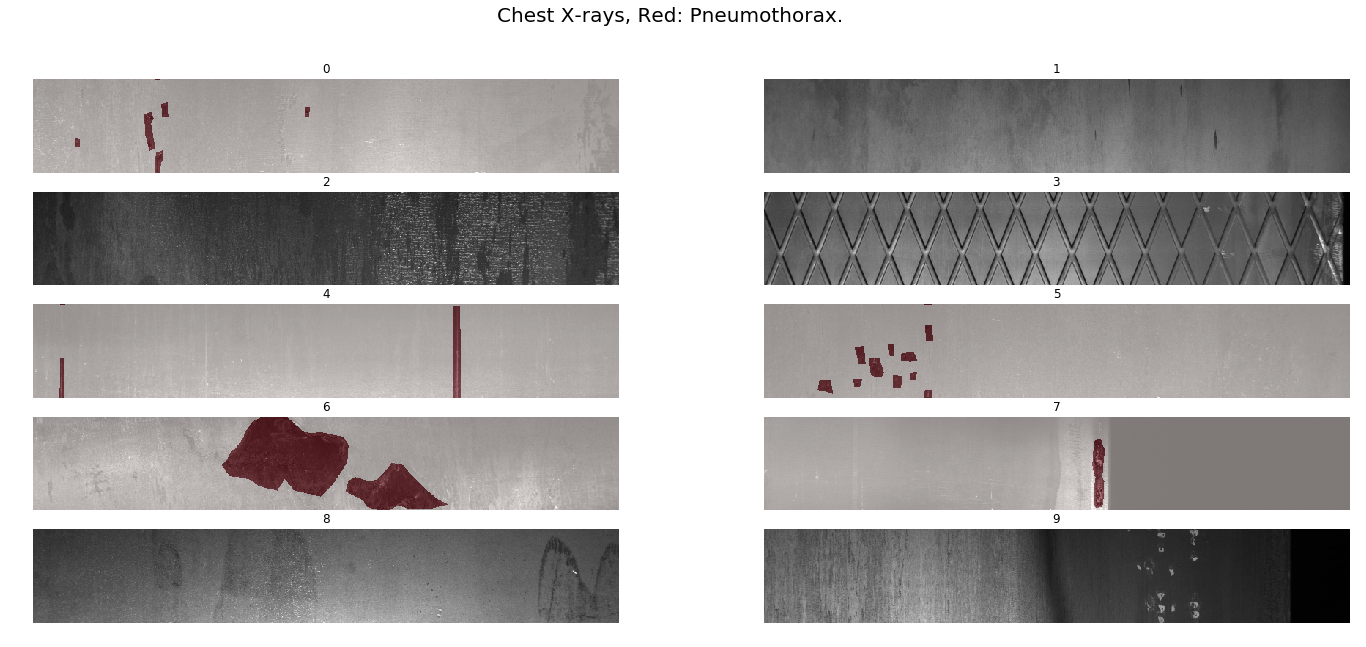

In [49]:
def print_test_data(data_gen , total_image , shrink=1, augmentation = None , shuffle = True):
    Dgen = data_gen(batch_size=total_image, shrink=shrink, shuffle=shuffle ,augmentation = augmentation)
    images, masks = Dgen.__getitem__(0)
    fig_width = 2
    fig_height = int(total_image/fig_width)
    fig, axes = plt.subplots(fig_height,fig_width,figsize=(fig_width*12,fig_height*2))

    for i, (im , mk) in enumerate(zip(images,masks)):
        ax = axes[int(i/fig_width),i%fig_width]
        ax.imshow(im.squeeze().astype('uint8'), cmap="bone")
        for idx in range(4):
            mask = mk[:,:,idx]
            if mask.sum() != 0:
                ax.imshow(mask.astype('uint8'), alpha=0.5, cmap="Reds") 
        ax.title.set_text(i)
        ax.axis('off')
    plt.suptitle("Chest X-rays, Red: Pneumothorax.",fontsize=20)
    
print_test_data(Datagen,10,shuffle= False,shrink=2)

In [19]:
from albumentations import (
    Compose, HorizontalFlip, CLAHE, HueSaturationValue,
    RandomBrightness, RandomContrast, RandomGamma,OneOf,
    ToFloat, ShiftScaleRotate,GridDistortion, ElasticTransform, JpegCompression, HueSaturationValue,
    RGBShift, RandomBrightness, RandomContrast, Blur, MotionBlur, MedianBlur, GaussNoise,CenterCrop,
    IAAAdditiveGaussianNoise,GaussNoise,OpticalDistortion,RandomSizedCrop
)

AUGMENTATIONS_TRAIN = Compose([
    HorizontalFlip(p=0.5),
    OneOf([
        RandomContrast(),
        RandomGamma(),
        RandomBrightness(),
         ], p=0.5),
    OneOf([
        ElasticTransform(alpha=100, sigma=150 * 0.05, alpha_affine=150 * 0.03),
        GridDistortion(),
        OpticalDistortion(distort_limit=0.5, shift_limit=0.5),
        ], p=0.2),
    ToFloat(max_value=1)
],p=1)


AUGMENTATIONS_TEST = Compose([
    ToFloat(max_value=1)
],p=1)

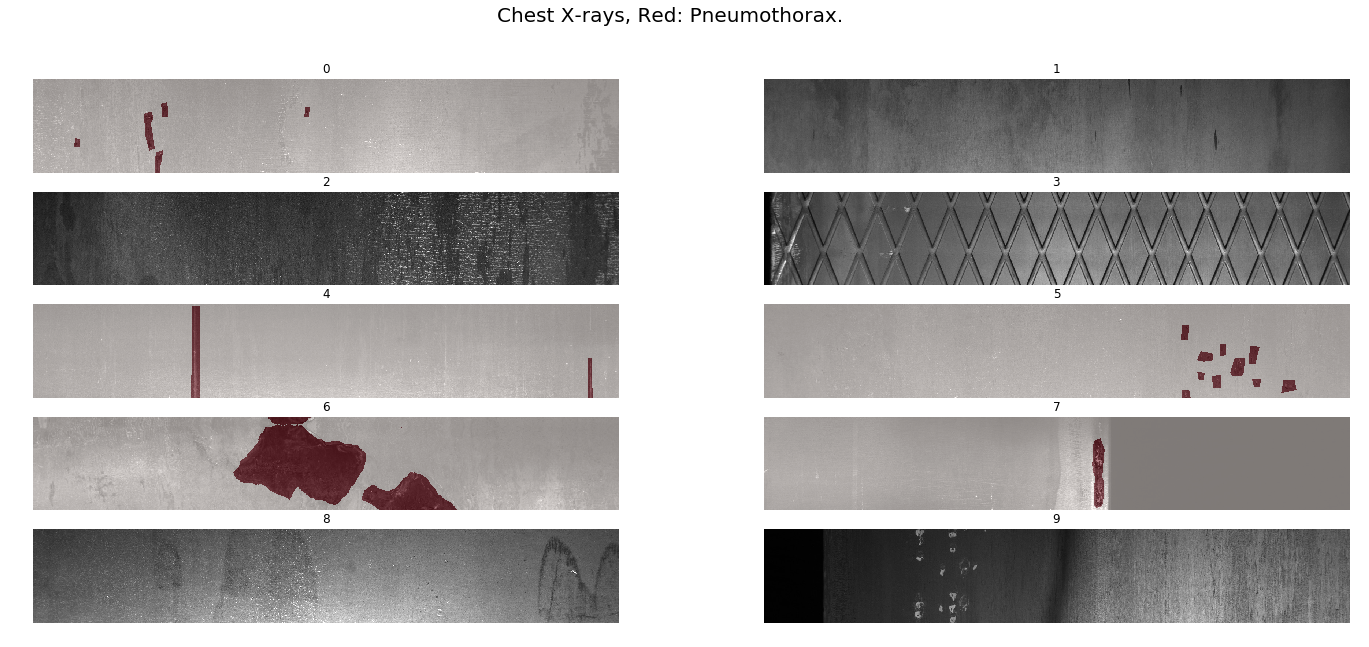

In [20]:
print_test_data(Datagen,10,augmentation = AUGMENTATIONS_TRAIN ,shuffle= False)

In [21]:
# https://www.kaggle.com/cpmpml/fast-iou-metric-in-numpy-and-tensorflow
def get_iou_vector(A, B):
    # Numpy version    
    batch_size = A.shape[0]
    metric = 0.0
    smooth = 1e-6
    B = B > 0.5
    for batch in range(batch_size):
        t, p = A[batch], B[batch]
        true = np.sum(t)
        pred = np.sum(p)
        
        # deal with empty mask first
        '''
        if true == 0:
            metric += (pred == 0)
            continue
        '''
        
        # non empty mask case.  Union is never empty 
        # hence it is safe to divide by its number of pixels
        intersection = np.sum(t * p)
        union = true + pred - intersection
        iou = (intersection+smooth) / (union+smooth)
        
        # iou metrric is a stepwise approximation of the real iou over 0.5
        iou = np.floor(max(0, (iou - 0.5)*20)) / 10
        
        metric += iou
        
    # teake the average over all images in batch
    metric /= batch_size
    return metric


def my_iou_metric(label, pred):
    # Tensorflow version
    return tf.py_func(get_iou_vector, [label, pred], tf.float64)

In [22]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

In [23]:
def cbam_block(cbam_feature, channel, ratio = 4, kernel_size = 7):

    cbam_feature = channel_attention(cbam_feature, channel, ratio)
    cbam_feature = spatial_attention(cbam_feature, kernel_size)
    return cbam_feature

def channel_attention(input_feature, channel, ratio=4):

    shared_layer_one = Dense(channel//ratio, activation='relu')
    shared_layer_two = Dense(channel)

    avg_pool = GlobalAveragePooling2D()(input_feature)    
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)

    max_pool = GlobalMaxPooling2D()(input_feature)
    max_pool = shared_layer_one(max_pool)  
    max_pool = shared_layer_two(max_pool)
    
    cbam_feature = Add()([avg_pool,max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)

    return multiply([input_feature, cbam_feature])

def spatial_attention(input_feature,kernel_size):

    avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(input_feature)
    max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(input_feature)

    concat = Concatenate(axis=3)([avg_pool, max_pool])
    
    cbam_feature = Conv2D(filters = 1,
                          kernel_size=kernel_size,
                          strides=1,
                          padding='same',
                          activation='sigmoid',
                          use_bias=False)(concat)

    return multiply([input_feature, cbam_feature])

In [24]:
def cbam_convolution_block(x, filters, size=(3,3), strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = cbam_block(x,filters)
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = cbam_block(x,filters)
    return x

def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    if activation == True:
        x = LeakyReLU(alpha=0.1)(x)
    return x

def residual_block(blockInput, num_filters=16):
    x = BatchNormalization()(blockInput)
    x = LeakyReLU(alpha=0.1)(x)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    return x

def attn_block(signal,blockInput):
    signal_shape = K.int_shape(signal)
    blockInput_shape = K.int_shape(blockInput)
    
    #signal = Conv2D(signal_shape[3], (1,1), strides=(1,1), padding='same')(signal)
    #signal = BatchNormalization()(signal)
    #signal = LeakyReLU(alpha=0.1)(signal)
    
    signal = Conv2D(blockInput_shape[3], (1,1), strides=(1,1), padding='same')(signal)
    theta_Input = Conv2D(blockInput_shape[3], (2,2), 
                         strides=(blockInput_shape[1]//signal_shape[1],blockInput_shape[2]//signal_shape[2]), 
                         padding='same')(blockInput)
    
    Add_s_t = Add()([theta_Input, signal])
    Add_s_t = BatchNormalization()(Add_s_t)
    Add_s_t = Activation('relu')(Add_s_t)
    Add_s_t = Conv2D(1, (1,1), strides=(1,1), padding='same')(Add_s_t)
    Add_s_t = BatchNormalization()(Add_s_t)
    Add_s_t = Activation('sigmoid')(Add_s_t)
    
    Add_s_t = UpSampling2D(size=(blockInput_shape[1]//signal_shape[1],blockInput_shape[2]//signal_shape[2]))(Add_s_t)
    
    OutputL = Multiply()([blockInput,Add_s_t])
    
    return OutputL

In [51]:
from efficientnet import EfficientNetB4


def UEfficientNet(input_shape=(None, None, 3),dropout_rate=0.1):

    backbone = EfficientNetB4(weights='imagenet', include_top=False,
                              input_shape=input_shape, classes = 4)
    input = backbone.input
    start_neurons = 8

    conv4 = backbone.layers[342].output
    conv4 = LeakyReLU(alpha=0.1)(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(dropout_rate)(pool4)
    
     # Middle
    convm = Conv2D(start_neurons * 32, (3, 3), activation=None, padding="same",name='conv_middle')(pool4)
    convm = cbam_convolution_block(convm,start_neurons * 32)
    convm = cbam_convolution_block(convm,start_neurons * 32)

    deconv4 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(convm)
    deconv4_up1 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(deconv4)
    deconv4_up2 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(deconv4_up1)
    deconv4_up3 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(deconv4_up2)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(dropout_rate)(uconv4) 
    
    uconv4 = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = cbam_convolution_block(uconv4,start_neurons * 16)

    
    deconv3 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(uconv4)
    deconv3_up1 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(deconv3)
    deconv3_up2 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(deconv3_up1)
    conv3 = backbone.layers[154].output
    uconv3 = concatenate([deconv3,deconv4_up1, conv3])    
    uconv3 = Dropout(dropout_rate)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = cbam_convolution_block(uconv3,start_neurons * 8)


    deconv2 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv3)
    deconv2_up1 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(deconv2)
    conv2 = backbone.layers[92].output
    uconv2 = concatenate([deconv2,deconv3_up1,deconv4_up2, conv2])
        
    uconv2 = Dropout(0.1)(uconv2)
    uconv2 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = cbam_convolution_block(uconv2,start_neurons * 4)

    
    deconv1 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv2)
    conv1 = backbone.layers[30].output
    uconv1 = concatenate([deconv1,deconv2_up1,deconv3_up2,deconv4_up3, conv1])
    
    uconv1 = Dropout(0.1)(uconv1)
    uconv1 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = cbam_convolution_block(uconv1,start_neurons * 2)

    
    uconv0 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv1)   
    uconv0 = Dropout(0.1)(uconv0)
    uconv0 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv0)
    uconv0 = cbam_convolution_block(uconv0,start_neurons * 1)

    
    uconv0 = Dropout(dropout_rate/2)(uconv0)
    output_layer = Conv2D(4, (1,1), padding="same", activation="sigmoid")(uconv0)    
    
    model = Model(input, output_layer)
    model.name = 'u-xception'

    return model

In [53]:
model = UEfficientNet(input_shape=(image_size[0]//shrink,image_size[1]//shrink,3),dropout_rate=0.5)
model.summary()

model.compile(loss=dice_loss, optimizer='adam', metrics=[my_iou_metric])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Shapes are always computed; don't use the compute_shapes as it has no effect.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 800, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 400, 48)  1296        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (Non

__________________________________________________________________________________________________
batch_normalization_7 (BatchNor (None, 32, 200, 144) 576         depthwise_conv2d_3[0][0]         
__________________________________________________________________________________________________
swish_7 (Swish)                 (None, 32, 200, 144) 0           batch_normalization_7[0][0]      
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 1, 1, 144)    0           swish_7[0][0]                    
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 1, 1, 6)      870         lambda_3[0][0]                   
__________________________________________________________________________________________________
swish_8 (Swish)                 (None, 1, 1, 6)      0           conv2d_9[0][0]                   
__________

__________________________________________________________________________________________________
batch_normalization_14 (BatchNo (None, 32, 200, 32)  128         conv2d_19[0][0]                  
__________________________________________________________________________________________________
drop_connect_3 (DropConnect)    (None, 32, 200, 32)  0           batch_normalization_14[0][0]     
__________________________________________________________________________________________________
add_3 (Add)                     (None, 32, 200, 32)  0           drop_connect_3[0][0]             
                                                                 add_2[0][0]                      
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 32, 200, 192) 6144        add_3[0][0]                      
__________________________________________________________________________________________________
batch_norm

__________________________________________________________________________________________________
lambda_8 (Lambda)               (None, 1, 1, 336)    0           swish_22[0][0]                   
__________________________________________________________________________________________________
conv2d_29 (Conv2D)              (None, 1, 1, 14)     4718        lambda_8[0][0]                   
__________________________________________________________________________________________________
swish_23 (Swish)                (None, 1, 1, 14)     0           conv2d_29[0][0]                  
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 1, 1, 336)    5040        swish_23[0][0]                   
__________________________________________________________________________________________________
activation_8 (Activation)       (None, 1, 1, 336)    0           conv2d_30[0][0]                  
__________

conv2d_39 (Conv2D)              (None, 16, 100, 56)  18816       multiply_10[0][0]                
__________________________________________________________________________________________________
batch_normalization_29 (BatchNo (None, 16, 100, 56)  224         conv2d_39[0][0]                  
__________________________________________________________________________________________________
drop_connect_7 (DropConnect)    (None, 16, 100, 56)  0           batch_normalization_29[0][0]     
__________________________________________________________________________________________________
add_7 (Add)                     (None, 16, 100, 56)  0           drop_connect_7[0][0]             
                                                                 add_6[0][0]                      
__________________________________________________________________________________________________
conv2d_40 (Conv2D)              (None, 16, 100, 336) 18816       add_7[0][0]                      
__________

swish_37 (Swish)                (None, 8, 50, 672)   0           batch_normalization_37[0][0]     
__________________________________________________________________________________________________
lambda_13 (Lambda)              (None, 1, 1, 672)    0           swish_37[0][0]                   
__________________________________________________________________________________________________
conv2d_49 (Conv2D)              (None, 1, 1, 28)     18844       lambda_13[0][0]                  
__________________________________________________________________________________________________
swish_38 (Swish)                (None, 1, 1, 28)     0           conv2d_49[0][0]                  
__________________________________________________________________________________________________
conv2d_50 (Conv2D)              (None, 1, 1, 672)    19488       swish_38[0][0]                   
__________________________________________________________________________________________________
activation

__________________________________________________________________________________________________
conv2d_59 (Conv2D)              (None, 8, 50, 112)   75264       multiply_15[0][0]                
__________________________________________________________________________________________________
batch_normalization_44 (BatchNo (None, 8, 50, 112)   448         conv2d_59[0][0]                  
__________________________________________________________________________________________________
drop_connect_11 (DropConnect)   (None, 8, 50, 112)   0           batch_normalization_44[0][0]     
__________________________________________________________________________________________________
add_11 (Add)                    (None, 8, 50, 112)   0           drop_connect_11[0][0]            
                                                                 add_10[0][0]                     
__________________________________________________________________________________________________
conv2d_60 

__________________________________________________________________________________________________
swish_52 (Swish)                (None, 8, 50, 960)   0           batch_normalization_52[0][0]     
__________________________________________________________________________________________________
lambda_18 (Lambda)              (None, 1, 1, 960)    0           swish_52[0][0]                   
__________________________________________________________________________________________________
conv2d_69 (Conv2D)              (None, 1, 1, 40)     38440       lambda_18[0][0]                  
__________________________________________________________________________________________________
swish_53 (Swish)                (None, 1, 1, 40)     0           conv2d_69[0][0]                  
__________________________________________________________________________________________________
conv2d_70 (Conv2D)              (None, 1, 1, 960)    39360       swish_53[0][0]                   
__________

                                                                 swish_58[0][0]                   
__________________________________________________________________________________________________
conv2d_79 (Conv2D)              (None, 8, 50, 160)   153600      multiply_20[0][0]                
__________________________________________________________________________________________________
batch_normalization_59 (BatchNo (None, 8, 50, 160)   640         conv2d_79[0][0]                  
__________________________________________________________________________________________________
drop_connect_15 (DropConnect)   (None, 8, 50, 160)   0           batch_normalization_59[0][0]     
__________________________________________________________________________________________________
add_15 (Add)                    (None, 8, 50, 160)   0           drop_connect_15[0][0]            
                                                                 add_14[0][0]                     
__________

__________________________________________________________________________________________________
swish_66 (Swish)                (None, 8, 50, 960)   0           batch_normalization_66[0][0]     
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 8, 50, 960)   0           swish_66[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 4, 25, 960)   0           leaky_re_lu_1[0][0]              
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 4, 25, 960)   0           max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
conv_middle (Conv2D)            (None, 4, 25, 256)   2212096     dropout_1[0][0]                  
__________

__________________________________________________________________________________________________
conv2d_133 (Conv2D)             (None, 4, 25, 256)   590080      multiply_36[0][0]                
__________________________________________________________________________________________________
batch_normalization_99 (BatchNo (None, 4, 25, 256)   1024        conv2d_133[0][0]                 
__________________________________________________________________________________________________
leaky_re_lu_4 (LeakyReLU)       (None, 4, 25, 256)   0           batch_normalization_99[0][0]     
__________________________________________________________________________________________________
global_average_pooling2d_3 (Glo (None, 256)          0           leaky_re_lu_4[0][0]              
__________________________________________________________________________________________________
global_max_pooling2d_3 (GlobalM (None, 256)          0           leaky_re_lu_4[0][0]              
__________

conv2d_138 (Conv2D)             (None, 8, 50, 128)   147584      conv2d_137[0][0]                 
__________________________________________________________________________________________________
batch_normalization_101 (BatchN (None, 8, 50, 128)   512         conv2d_138[0][0]                 
__________________________________________________________________________________________________
leaky_re_lu_6 (LeakyReLU)       (None, 8, 50, 128)   0           batch_normalization_101[0][0]    
__________________________________________________________________________________________________
global_average_pooling2d_5 (Glo (None, 128)          0           leaky_re_lu_6[0][0]              
__________________________________________________________________________________________________
global_max_pooling2d_5 (GlobalM (None, 128)          0           leaky_re_lu_6[0][0]              
__________________________________________________________________________________________________
dense_9 (D

conv2d_142 (Conv2D)             (None, 16, 100, 64)  304192      dropout_3[0][0]                  
__________________________________________________________________________________________________
conv2d_143 (Conv2D)             (None, 16, 100, 64)  36928       conv2d_142[0][0]                 
__________________________________________________________________________________________________
batch_normalization_103 (BatchN (None, 16, 100, 64)  256         conv2d_143[0][0]                 
__________________________________________________________________________________________________
leaky_re_lu_8 (LeakyReLU)       (None, 16, 100, 64)  0           batch_normalization_103[0][0]    
__________________________________________________________________________________________________
global_average_pooling2d_7 (Glo (None, 64)           0           leaky_re_lu_8[0][0]              
__________________________________________________________________________________________________
global_max

                                                                 conv2d_transpose_3[0][0]         
                                                                 swish_18[0][0]                   
__________________________________________________________________________________________________
dropout_4 (Dropout)             (None, 32, 200, 416) 0           concatenate_11[0][0]             
__________________________________________________________________________________________________
conv2d_147 (Conv2D)             (None, 32, 200, 32)  119840      dropout_4[0][0]                  
__________________________________________________________________________________________________
conv2d_148 (Conv2D)             (None, 32, 200, 32)  9248        conv2d_147[0][0]                 
__________________________________________________________________________________________________
batch_normalization_105 (BatchN (None, 32, 200, 32)  128         conv2d_148[0][0]                 
__________

__________________________________________________________________________________________________
conv2d_transpose_7 (Conv2DTrans (None, 64, 400, 64)  36928       conv2d_transpose_6[0][0]         
__________________________________________________________________________________________________
conv2d_transpose_4 (Conv2DTrans (None, 64, 400, 128) 147584      conv2d_transpose_3[0][0]         
__________________________________________________________________________________________________
concatenate_14 (Concatenate)    (None, 64, 400, 384) 0           conv2d_transpose_10[0][0]        
                                                                 conv2d_transpose_9[0][0]         
                                                                 conv2d_transpose_7[0][0]         
                                                                 conv2d_transpose_4[0][0]         
                                                                 swish_6[0][0]                    
__________

conv2d_156 (Conv2D)             (None, 64, 400, 1)   98          concatenate_16[0][0]             
__________________________________________________________________________________________________
multiply_56 (Multiply)          (None, 64, 400, 16)  0           multiply_55[0][0]                
                                                                 conv2d_156[0][0]                 
__________________________________________________________________________________________________
conv2d_transpose_11 (Conv2DTran (None, 128, 800, 8)  1160        multiply_56[0][0]                
__________________________________________________________________________________________________
dropout_6 (Dropout)             (None, 128, 800, 8)  0           conv2d_transpose_11[0][0]        
__________________________________________________________________________________________________
conv2d_157 (Conv2D)             (None, 128, 800, 8)  584         dropout_6[0][0]                  
__________

__________________________________________________________________________________________________
dropout_7 (Dropout)             (None, 128, 800, 8)  0           multiply_60[0][0]                
__________________________________________________________________________________________________
conv2d_162 (Conv2D)             (None, 128, 800, 4)  36          dropout_7[0][0]                  
Total params: 11,622,476
Trainable params: 11,568,860
Non-trainable params: 53,616
__________________________________________________________________________________________________
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient

In [54]:
class SWA(keras.callbacks.Callback):
    
    def __init__(self, filepath, swa_epoch):
        super(SWA, self).__init__()
        self.filepath = filepath
        self.swa_epoch = swa_epoch 
    
    def on_train_begin(self, logs=None):
        self.nb_epoch = self.params['epochs']
        print('Stochastic weight averaging selected for last {} epochs.'
              .format(self.nb_epoch - self.swa_epoch))
        
    def on_epoch_end(self, epoch, logs=None):
        
        if epoch == self.swa_epoch:
            self.swa_weights = self.model.get_weights()
            
        elif epoch > self.swa_epoch:    
            for i in range(len(self.swa_weights)):
                self.swa_weights[i] = (self.swa_weights[i] * 
                    (epoch - self.swa_epoch) + self.model.get_weights()[i])/((epoch - self.swa_epoch)  + 1)  

        else:
            pass
        
    def on_train_end(self, logs=None):
        self.model.set_weights(self.swa_weights)
        print('Final model parameters set to stochastic weight average.')
        self.model.save(self.filepath)
        print('Final stochastic averaged model saved to file.')

In [55]:
class SnapshotCallbackBuilder:
    def __init__(self, nb_epochs, nb_snapshots, init_lr=0.1):
        self.T = nb_epochs
        self.M = nb_snapshots
        self.alpha_zero = init_lr

    def get_callbacks(self, model_prefix='Model'):

        callback_list = [
            callbacks.ModelCheckpoint(model_name+'.model',monitor='val_my_iou_metric', 
                                   mode = 'max', save_best_only=True, verbose=1),
            swa,
            callbacks.LearningRateScheduler(schedule=self._cosine_anneal_schedule)
        ]

        return callback_list

    def _cosine_anneal_schedule(self, t):
        cos_inner = np.pi * (t % (self.T // self.M))  # t - 1 is used when t has 1-based indexing.
        cos_inner /= self.T // self.M
        cos_out = np.cos(cos_inner) + 1
        return float(self.alpha_zero / 2 * cos_out)

In [62]:
batch_size=4
epochs = 10

snapshot = SnapshotCallbackBuilder(nb_epochs=epochs,nb_snapshots=1,init_lr=0.5e-3)
swa = SWA(model_name+'_swa.model',5)
valid_im_path,valid_mask_path = './keras_im_val','./keras_mask_val'

# Generators
training_generator = Datagen(augmentation=AUGMENTATIONS_TRAIN,image_size=image_size,batch_size=batch_size)

validation_generator = Datagen(train_dir = VAL_DIR,
                               augmentation=AUGMENTATIONS_TEST, image_size=image_size,batch_size=batch_size)

history = model.fit_generator(generator=training_generator,
                              validation_data=validation_generator,  
                              use_multiprocessing=False,
                              epochs=epochs,verbose=2,
                              callbacks=snapshot.get_callbacks())

Stochastic weight averaging selected for last 5 epochs.
Epoch 1/10
 - 1614s - loss: 0.8802 - my_iou_metric: 0.0470 - val_loss: 0.5979 - val_my_iou_metric: 0.2668

Epoch 00001: val_my_iou_metric improved from -inf to 0.26685, saving model to Unetpluscbam.model
Epoch 2/10
 - 1601s - loss: 0.5893 - my_iou_metric: 0.3317 - val_loss: 0.4560 - val_my_iou_metric: 0.5072

Epoch 00002: val_my_iou_metric improved from 0.26685 to 0.50716, saving model to Unetpluscbam.model
Epoch 3/10


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.plot(history.history['my_iou_metric'][1:])
plt.plot(history.history['val_my_iou_metric'][1:])
plt.ylabel('iou')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')

plt.title('model IOU')

plt.subplot(1,2,2)
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'][1:])
plt.ylabel('val_loss')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')
plt.title('model loss')
#gc.collect()

In [ ]:
def predict_result(model,validation_generator): 
    preds_test1 = model.predict_generator(validation_generator)
    return preds_test1

In [ ]:
model.load(model_name+'.model')

In [ ]:
def cal_iou(y_true_in, y_pred_in):
    smooth = 1e-6
    y_true_in = y_true_in.astype('bool')
    true = np.sum(y_true_in)
    pred = np.sum(y_pred_in)
    intersection = np.sum(y_true_in * y_pred_in)
    union = true + pred - intersection
    iou = (intersection+smooth) / (union+smooth)
    iou = np.floor(max(0, (iou - 0.5)*20)) / 10
    return iou

def cal_iou_metric(y_true_in, y_pred_in):
    metric = []
    for y_t, y_p in zip(y_true_in,y_pred_in):
        metric.append(cal_iou(y_t,y_p))
    return np.mean(metric)

In [ ]:
thresholds = np.linspace(0.2, 0.9, 31)
iou_calculated = np.array([cal_iou_metric(y_valid_ori,preds_valid>threshold) for threshold in tqdm_notebook(thresholds)])

In [ ]:
threshold_best_index = np.argmax(iou_calculated) 
print(threshold_best_index)
iou_best = iou_calculated[threshold_best_index]
threshold_best_cal = thresholds[threshold_best_index]

plt.figure()
plt.plot(thresholds,iou_calculated)
plt.plot(threshold_best_cal,iou_best,'xr', label="Best threshold")
plt.legend()
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best_cal, iou_best))

In [ ]:
def print_val():
    validation_generator = Datagen(train_dir = VAL_DIR, mask_dir = VAL_MASK_DIR,
                               augmentation=AUGMENTATIONS_TEST,
                               image_size=image_size,shuffle=False)

    AUGMENTATIONS_TEST_FLIPPED = Compose([HorizontalFlip(p=1),ToFloat(max_value=1)],p=1)

    validation_generator_flipped = Datagen(train_dir = VAL_DIR, mask_dir=VAL_MASK_DIR,
                                           augmentation=AUGMENTATIONS_TEST_FLIPPED,
                                           image_size=image_size,shuffle=False)

    preds_valid_orig = predict_result(model,validation_generator,image_size)
    preds_valid_flipped = predict_result(model,validation_generator_flipped,image_size)
    preds_valid_flipped = np.array([np.fliplr(x) for x in preds_valid_flipped])
    preds_valid = 0.5*preds_valid_orig + 0.5*preds_valid_flipped
    
    